In [1]:
# 导入相应的库
import keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import itertools
import os
import keras

In [2]:
# 初始设置
im_height = 224 
im_width = 224
batch_size = 32
epochs = 50
num_classes = 3
labels = ['1','2','3']
save_path = './save_weights/effb2-{epoch:02d}-{val_accuracy:.2f}.h5'

image_path = 'G:/dataset/panicle_period/'
train_dir = image_path + "train"
val_dir = image_path + "val"
test_dir = image_path + "test"

In [3]:
# 数据预处理
train_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
#     rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
#     shear_range=0.2,
#     zoom_range=0.2,
#     rotation_range = 20,
#     brightness_range = (1.2, 1.5)
)
val_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)
test_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [4]:
# 生成数据
train_data_gen = train_image_generator.flow_from_directory(directory=train_dir,
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           color_mode="rgb",
                                                           target_size=(im_height, im_width),
                                                           class_mode='categorical')
total_train = train_data_gen.n

val_data_gen = val_image_generator.flow_from_directory( directory=val_dir,
                                                          batch_size=batch_size,
                                                          shuffle=False,
                                                       color_mode="rgb",
                                                          target_size=(im_height, im_width),
                                                          class_mode='categorical')
total_val = val_data_gen.n

test_data_gen = test_image_generator.flow_from_directory( directory=test_dir,
                                                          batch_size=batch_size,
                                                          shuffle=False,
                                                         color_mode="rgb",
                                                          target_size=(im_height, im_width),
                                                          class_mode='categorical')
total_test = test_data_gen.n

Found 39688 images belonging to 3 classes.
Found 13231 images belonging to 3 classes.
Found 13231 images belonging to 3 classes.


In [5]:
# weight_for_0 = (1 / 1341)*(total_train)/2.0 
# weight_for_1 = (1 / 3875)*(total_train)/2.0

# class_weight = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [6]:
# 构建模型
covn_base = tf.keras.applications.EfficientNetB2(weights='imagenet', include_top = False,
                                              input_shape=(im_height,im_width,3))
covn_base.trainable = False
model = tf.keras.Sequential([
        covn_base,
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(units = 32, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax',
                              kernel_regularizer='l2'
                             )
    ])
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 7, 7, 1408)        7768569   
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 1408)        5632      
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1408)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                45088     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

In [7]:
# 编译模型
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
# try:
#     model.load_weights("./save_weights/DenseNet201.ckpt")
#     print("载入模型成果！继续训练模型")
# except :    
#     print("载入模型失败！开始训练一个新模型")

In [9]:
# 开始训练
# 监视’val_loss’的变化，如果两个轮次不变学习率衰减为原来的1/10
reduce_lr = ReduceLROnPlateau(
                                monitor='val_loss', 
                                factor=0.2, 
                                patience=3, 
                                mode='auto',
                                verbose=1
                             )

# 设置模型保存路径，且根据val_acc保存最优模型
checkpoint = ModelCheckpoint(
                                filepath=save_path,
                                monitor='val_accuracy', 
                                save_weights_only=False, 
                                save_best_only=True, 
                                mode='auto',
                                period=1
                            )

history = model.fit(x=train_data_gen,
                    steps_per_epoch=total_train // batch_size,
                    epochs=epochs,
                    validation_data=val_data_gen,
                    validation_steps=total_val // batch_size,
                    verbose=1,
#                     class_weight=class_weight,
                    callbacks=[checkpoint, reduce_lr])

Epoch 1/50
1240/1240 [==============================] - 125s 101ms/step - loss: 0.3390 - accuracy: 0.8801 - val_loss: 0.2108 - val_accuracy: 0.9309
Epoch 2/50
1240/1240 [==============================] - 113s 91ms/step - loss: 0.2583 - accuracy: 0.9055 - val_loss: 0.1974 - val_accuracy: 0.9286
Epoch 3/50
1240/1240 [==============================] - 113s 91ms/step - loss: 0.2329 - accuracy: 0.9149 - val_loss: 0.1472 - val_accuracy: 0.9532
Epoch 4/50
1240/1240 [==============================] - 115s 93ms/step - loss: 0.2229 - accuracy: 0.9197 - val_loss: 0.1451 - val_accuracy: 0.9542
Epoch 5/50
1240/1240 [==============================] - 115s 93ms/step - loss: 0.2153 - accuracy: 0.9208 - val_loss: 0.1467 - val_accuracy: 0.9480
Epoch 6/50
1240/1240 [==============================] - 115s 93ms/step - loss: 0.2118 - accuracy: 0.9238 - val_loss: 0.1307 - val_accuracy: 0.9569
Epoch 7/50
1240/1240 [==============================] - 115s 92ms/step - loss: 0.2021 - accuracy: 0.9249 - val_loss: 

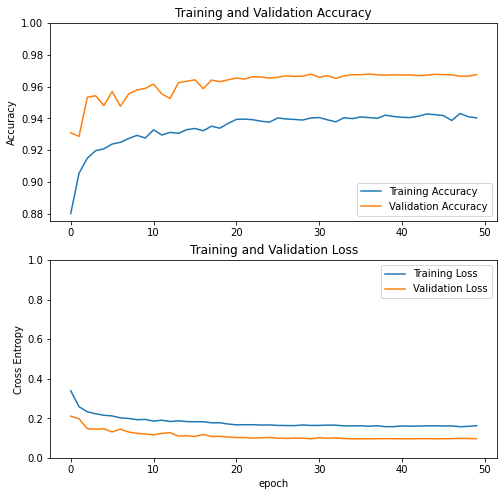

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [11]:
# 绘制混淆矩阵
def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    print(cm)
    accuracy = np.trace(cm) / float(np.sum(cm)) #计算准确率
#     misclass = 1 - accuracy #计算错误率
    precision = cm[0][0]/cm.sum(axis=0)[0]
    recall = cm[0][0]/cm.sum(axis=1)[0]
    f1 = 2*precision*recall/(precision + recall)
    if cmap is None:
        cmap = plt.get_cmap('Blues') #颜色设置成蓝色
    plt.figure(figsize=(5, 4)) #设置窗口尺寸
    plt.imshow(cm, interpolation='nearest', cmap=cmap) #显示图片
    plt.title(title) #显示标题
    plt.colorbar() #绘制颜色条

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45) #x坐标标签旋转45度
        plt.yticks(tick_marks, target_names) #y坐标

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2) #对数字保留两位小数

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    #将cm.shape[0]、cm.shape[1]中的元素组成元组，遍历元组中每一个数字
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): 
        if normalize: #标准化
            plt.text(j, i, "{:0.2f}".format(cm[i, j]), #保留两位小数
                     horizontalalignment="center",  #数字在方框中间
                     color="white" if cm[i, j] > thresh else "black")  #设置字体颜色
        else:  #非标准化
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",  #数字在方框中间
                     color="white" if cm[i, j] > thresh else "black") #设置字体颜色

    plt.tight_layout() #自动调整子图参数,使之填充整个图像区域
    plt.ylabel('True label') #y方向上的标签
    #x方向上的标签
    plt.xlabel("Predicted label\n\naccuracy={:0.4f}\n precision={:0.4f}\n recall={:0.4f}\n F1={:0.4f}"
               .format(accuracy, precision, recall, f1))
#     plt.savefig("cm_cnn.png")
    plt.show() #显示图片

In [12]:
# # print(Y_pred)
# # , total_train // batch_size + 1
# # Y_pred = model.predict_generator(train_data_gen)
# Y_pred = model.predict(train_data_gen)
# Y_pred_classes = np.argmax(Y_pred, axis = 1)
# print(Y_pred_classes.shape)
# print(train_data_gen.classes.shape)

In [13]:
# train_data_gen.labels.shape
# confusion_mtx = confusion_matrix(y_true = train_data_gen.classes,y_pred = Y_pred_classes)
# print(confusion_mtx)

In [14]:
# # 计算训练集混淆矩阵
# Y_pred = model.predict_generator(train_data_gen, total_train // batch_size + 1)
# Y_pred_classes = np.argmax(Y_pred, axis = 1)
# confusion_mtx = confusion_matrix(y_true = train_data_gen.classes,y_pred = Y_pred_classes)
# print(confusion_mtx)

In [15]:
# # 计算验证集混淆矩阵
# Y_pred = model.predict_generator(val_data_gen, total_val // batch_size + 1)
# Y_pred_classes = np.argmax(Y_pred, axis = 1)
# confusion_mtx = confusion_matrix(y_true = val_data_gen.classes,y_pred = Y_pred_classes)
# print(confusion_mtx)

In [16]:
test_loss, test_acc = model.evaluate(train_data_gen)

print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

1241/1241 [==============================] - 88s 71ms/step - loss: 0.0866 - accuracy: 0.9722

Test accuracy: 0.9722334146499634

Test loss: 0.08659438043832779


In [17]:
test_loss, test_acc = model.evaluate(val_data_gen)

print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

414/414 [==============================] - 29s 71ms/step - loss: 0.0965 - accuracy: 0.9675

Test accuracy: 0.9675005674362183

Test loss: 0.09647264331579208


In [18]:
test_loss, test_acc = model.evaluate(test_data_gen)

print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

414/414 [==============================] - 28s 67ms/step - loss: 0.0988 - accuracy: 0.9675

Test accuracy: 0.9675005674362183

Test loss: 0.09879080206155777


Instructions for updating:
Please use Model.predict, which supports generators.
[[1996   23    2]
 [  44 4421  284]
 [   5   72 6384]]


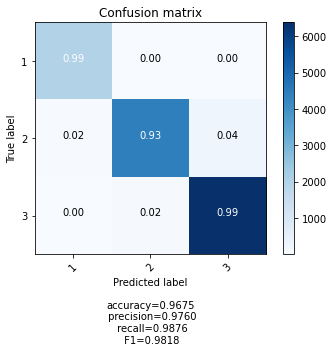

In [19]:
# 预测测试集数据整体准确率
Y_pred = model.predict_generator(test_data_gen, total_test // batch_size + 1)
# 将预测的结果转化为one hit向量
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# 计算混淆矩阵
confusion_mtx = confusion_matrix(y_true = test_data_gen.classes,y_pred = Y_pred_classes)
# 绘制混淆矩阵
plot_confusion_matrix(confusion_mtx, normalize=True, target_names=labels)

[[1998   22    1]
 [  49 4430  270]
 [   2   86 6373]]


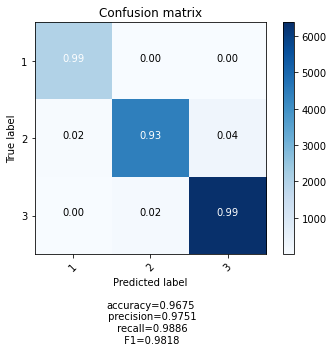

In [20]:
# 预测验证集数据整体准确率
Y_pred = model.predict_generator(val_data_gen, total_val // batch_size + 1)
# 将预测的结果转化为one hit向量
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# 计算混淆矩阵
confusion_mtx = confusion_matrix(y_true = val_data_gen.classes,y_pred = Y_pred_classes)
# 绘制混淆矩阵
plot_confusion_matrix(confusion_mtx, normalize=True, target_names=labels)

[[ 950 2062 3050]
 [2138 4980 7127]
 [3036 6631 9714]]


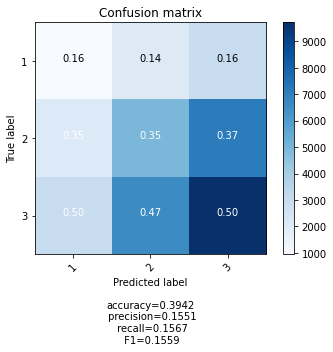

In [21]:
# 预测训练集数据整体准确率
Y_pred = model.predict_generator(train_data_gen, total_train // batch_size + 1)
# 将预测的结果转化为one hit向量
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# 计算混淆矩阵
confusion_mtx = confusion_matrix(y_true = train_data_gen.classes,y_pred = Y_pred_classes)
# 绘制混淆矩阵
plot_confusion_matrix(confusion_mtx, normalize=True, target_names=labels)

In [22]:
# 遍历测试集的图片
test_dir = os.path.join(image_path,"test")
dirs = ['0']* len(labels)
print(dirs)
for i in range(len(labels)):
#     print(os.path.join(test_dir,labels[i]))
    dirs[i] = os.path.join(test_dir,labels[i])
img_path1 = []
for x in range(len(dirs)):
    num = 0
    for i in os.listdir(dirs[x]): 
        if os.path.splitext(i)[1] == ".jpg":   
            img_path1.append(os.path.join(test_dir,dirs[x],i))
            num+=1
        if(num>=4):
            break

['0', '0', '0']


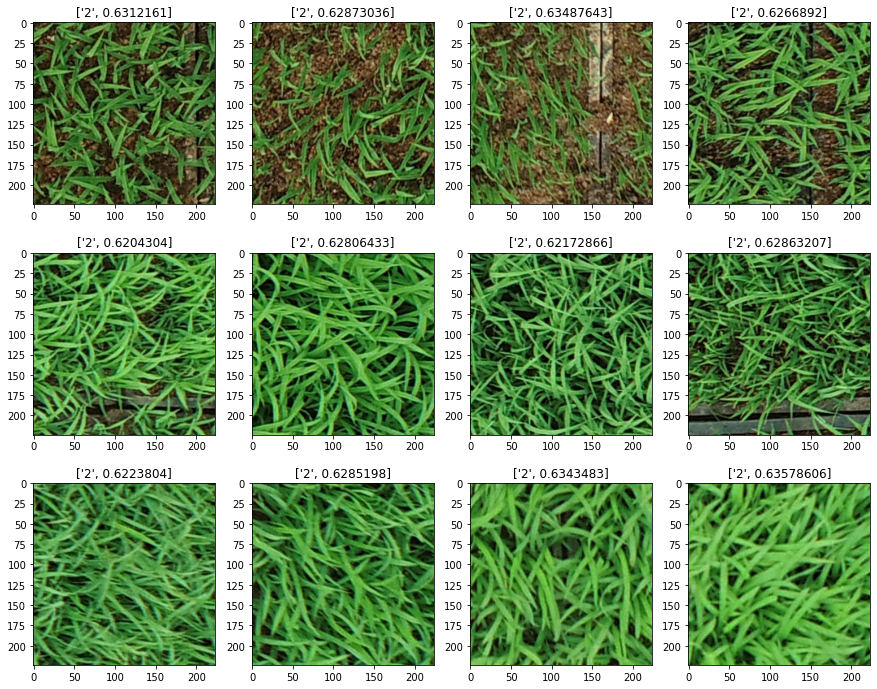

In [23]:
# 测试模型
#获取数据集的类别编码
class_indices = train_data_gen.class_indices 
#将编码和对应的类别存入字典
inverse_dict = dict((val, key) for key, val in class_indices.items()) 
fig = plt.figure(figsize=(15,12))
a=1
#加载测试图片
for i in img_path1:
    img = Image.open(i)
    # 将图片resize到224x224大小
    img = img.resize((im_width, im_height))
    #将灰度图转化为RGB模式
    img = img.convert("RGB")
    # 归一化
    img1 = np.array(img) / 255.
    # 将图片增加一个维度，目的是匹配网络模型
    img1 = (np.expand_dims(img1, 0))
    #将预测结果转化为概率值
    result = np.squeeze(model.predict(img1))
    predict_class = np.argmax(result)
    #print(inverse_dict[int(predict_class)],result[predict_class])
    plt.subplot(3,4,a)
    a+=1
    #将预测的结果打印在图片上面
    plt.title([inverse_dict[int(predict_class)],result[predict_class]])
    #显示图片
    plt.imshow(img)
plt.show()